In [ ]:
# Run if on Google Colab
import os
if os.path.isdir('/content/dsml_final_project'):
  !rm -rf /content/dsml_final_project
if not os.path.isdir('/content/saved_models'):
  !mkdir /content/saved_models
!cd /content; git clone --branch wesley_branch https://github.com/wglao/dsml_final_project.git
import sys
sys.path.append('/content/dsml_final_project')
!pip install wandb
!pip install equinox
# !pip install --upgrade torch #torchvision torchtext torchaudio

Cloning into 'dsml_final_project'...
remote: Enumerating objects: 455, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 455 (delta 18), reused 33 (delta 7), pack-reused 377
Receiving objects: 100% (455/455), 752.24 KiB | 2.43 MiB/s, done.
Resolving deltas: 100% (208/208), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
# imports
import os
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_enable_triton_softmax_fusion=true '
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_async_collectives=true '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
    '--xla_gpu_enable_highest_priority_async_stream=true '
)
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jrd
import equinox as eqx
import optax as opx
import torch
import torch._dynamo
torch._dynamo.config.suppress_errors = True
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from models.models import MLP, MLPFunction, ResNet, Siren, SirenTrunk, TrunkNet, DeepONet, eTrunk, eONet, eMLP
from utils.data import PatientDataset
from utils.train import naive_train, noisy_train_mlp, noisy_train_onet, noisy_train_MLPF, timeseries_MSE_loss, timeseries_L2_loss, timeseries_H1_loss, onet_test, jtrain_o_net, jL2_loss, j_onet_test

torch.set_float32_matmul_precision('high')

In [ ]:
HIDDEN_LAYERS = 3
HIDDEN_SIZE = 64
SEED = 5678
NUM_EPOCHS = 3000
PRINT_EVERY = 1000
LEARNING_RATE = 1e-4
BATCH_SIZE = 10
WANDB = False
DT = 1.
NOISE_VAR = 0.1

torch.manual_seed(SEED)

# branch and trunk nets
BASIS_DIM = 64

branch_dict = {
    "Net": eMLP,
    "Args":{
      "in_size": 11,
      "hidden_size": HIDDEN_SIZE,
      "out_size": BASIS_DIM,
      "layers": HIDDEN_LAYERS,
      "act": F.gelu
    },
}

trunk_dict = {
    "Net": eTrunk,
    "Args":{
      "hidden_size": HIDDEN_SIZE,
      "basis_dims": BASIS_DIM,
      "layers": HIDDEN_LAYERS,
      "act": F.gelu
    },
}


In [ ]:
# data
health_data_file = "/content/dsml_final_project/data/heart_failure_clinical_records_dataset.csv"
survival_file = "/content/dsml_final_project/data/survival_function_data.csv"

train_split = 90
num_patients = 299
ids = torch.randperm(num_patients)
split_id = int((num_patients*train_split)//100)
train_ids = ids[:split_id]
test_ids = ids[split_id:]

train_dataset = PatientDataset(health_data_file, survival_file, train_ids)
transforms=(train_dataset.transform, train_dataset.inv_transform)
test_dataset = PatientDataset(health_data_file, survival_file, test_ids, transforms=transforms)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE)

# 5-Fold CV
fold_size = int(num_patients//5)

train_1 = PatientDataset(health_data_file, survival_file, train_ids[:4*fold_size], transforms=transforms)
val_1 = PatientDataset(health_data_file, survival_file, train_ids[4*fold_size:], transforms=transforms)

train_2 = PatientDataset(health_data_file, survival_file, torch.concatenate([train_ids[:3*fold_size], train_ids[4*fold_size:]]), transforms=transforms)
val_2 = PatientDataset(health_data_file, survival_file, train_ids[3*fold_size:4*fold_size], transforms=transforms)

train_3 = PatientDataset(health_data_file, survival_file, torch.concatenate([train_ids[:2*fold_size], train_ids[3*fold_size:]]), transforms=transforms)
val_3 = PatientDataset(health_data_file, survival_file, train_ids[2*fold_size:3*fold_size], transforms=transforms)

train_4 = PatientDataset(health_data_file, survival_file, torch.concatenate([train_ids[:1*fold_size], train_ids[2*fold_size:]]), transforms=transforms)
val_4 = PatientDataset(health_data_file, survival_file, train_ids[1*fold_size:2*fold_size], transforms=transforms)

train_5 = PatientDataset(health_data_file, survival_file, train_ids[fold_size:], transforms=transforms)
val_5 = PatientDataset(health_data_file, survival_file, train_ids[:fold_size], transforms=transforms)

train_loader_1 = DataLoader(train_1, BATCH_SIZE, shuffle=True)
val_loader_1 = DataLoader(val_1, BATCH_SIZE)

train_loader_2 = DataLoader(train_2, BATCH_SIZE, shuffle=True)
val_loader_2 = DataLoader(val_2, BATCH_SIZE)

train_loader_3 = DataLoader(train_3, BATCH_SIZE, shuffle=True)
val_loader_3 = DataLoader(val_3, BATCH_SIZE)

train_loader_4 = DataLoader(train_4, BATCH_SIZE, shuffle=True)
val_loader_4 = DataLoader(val_4, BATCH_SIZE)

train_loader_5 = DataLoader(train_5, BATCH_SIZE, shuffle=True)
val_loader_5 = DataLoader(val_5, BATCH_SIZE)

train_loader_list = [train_loader_1, train_loader_2, train_loader_3, train_loader_4, train_loader_5]
val_loader_list = [val_loader_1, val_loader_2, val_loader_3, val_loader_4, val_loader_5]

In [ ]:
# model and optimizer
def create_models(hidden_size, hidden_layers, basis_dims):
  if basis_dims == 0:
    model_1 = torch.compile(MLPFunction(11,hidden_size,1,hidden_layers,act=F.gelu).cuda())
    opt_1 = Adam(model_1.parameters(), LEARNING_RATE)
    model_2 = torch.compile(MLPFunction(11,hidden_size,1,hidden_layers,act=F.gelu).cuda())
    opt_2 = Adam(model_2.parameters(), LEARNING_RATE)
    model_3 = torch.compile(MLPFunction(11,hidden_size,1,hidden_layers,act=F.gelu).cuda())
    opt_3 = Adam(model_3.parameters(), LEARNING_RATE)
    model_4 = torch.compile(MLPFunction(11,hidden_size,1,hidden_layers,act=F.gelu).cuda())
    opt_4 = Adam(model_4.parameters(), LEARNING_RATE)
    model_5 = torch.compile(MLPFunction(11,hidden_size,1,hidden_layers,act=F.gelu).cuda())
    opt_5 = Adam(model_5.parameters(), LEARNING_RATE)

  else:
    branch_dict = {
        "Net": MLP,
        "Args":{
          "in_size": 11,
          "hidden_size": hidden_size,
          "out_size": basis_dims,
          "layers": hidden_layers,
          "act": F.gelu
        },
    }

    trunk_dict = {
        "Net": TrunkNet,
        "Args":{
          "hidden_size": hidden_size,
          "basis_dims": basis_dims,
          "layers": hidden_layers,
          "act": F.gelu
        },
    }
    model_1 = torch.compile(DeepONet(branch_dict, trunk_dict).cuda())
    opt_1 = Adam(model_1.parameters(), LEARNING_RATE)
    model_2 = torch.compile(DeepONet(branch_dict, trunk_dict).cuda())
    opt_2 = Adam(model_2.parameters(), LEARNING_RATE)
    model_3 = torch.compile(DeepONet(branch_dict, trunk_dict).cuda())
    opt_3 = Adam(model_3.parameters(), LEARNING_RATE)
    model_4 = torch.compile(DeepONet(branch_dict, trunk_dict).cuda())
    opt_4 = Adam(model_4.parameters(), LEARNING_RATE)
    model_5 = torch.compile(DeepONet(branch_dict, trunk_dict).cuda())
    opt_5 = Adam(model_5.parameters(), LEARNING_RATE)

  model_list = [model_1, model_2, model_3, model_4, model_5]
  opt_list = [opt_1, opt_2, opt_3, opt_4, opt_5]

  return model_list, opt_list

In [ ]:
save_dir = "/content/saved_models"
# DeepONet
NET_NAME = "onet_test"
test_performance=[]
final_act = F.sigmoid
hiddens = [128,64,32]
layers = [3,2]
basis_dims = [64,32]
# 5FCV
# for hidden in hiddens:
#   #for basis_dim in basis_dims:
#     model_list, opt_list = create_models(hidden, 3, 0)
#     for i, model, opt, train_loader, val_loader in zip(np.arange(len(model_list)), model_list, opt_list, train_loader_list, val_loader_list):
#       # noisy_train_onet(model, opt, train_loader, val_loader, NUM_EPOCHS, loss_fn=timeseries_L2_loss, log_wandb=WANDB, name=NET_NAME+"_{:d}".format(i), print_every=PRINT_EVERY, save_dir=save_dir, dt=DT, noise_variance=NOISE_VAR, range_loss=1, ortho_loss=0, final_act=final_act)
#       noisy_train_MLPF(model, opt, train_loader, val_loader, NUM_EPOCHS, loss_fn=timeseries_L2_loss, log_wandb=WANDB, name=NET_NAME+"_{:d}".format(i), print_every=PRINT_EVERY, save_dir=save_dir, dt=DT, noise_variance=NOISE_VAR, range_loss=1, final_act=final_act)
#       model.eval()
#       test_performance.append(onet_test(model, test_loader, timeseries_L2_loss, final_act=final_act, cuda=True))

#     print(test_performance)
#     print(np.mean(test_performance))
#     print(np.std(test_performance))

# full train
branch_dict = {
    "Net": eMLP,
    "Args":{
      "in_size": 11,
      "hidden_size": 64,
      "out_size": 32,
      "layers": 3,
      "act": jax.nn.gelu
    },
}

trunk_dict = {
    "Net": TrunkNet,
    "Args":{
      "hidden_size": 64,
      "basis_dims": 32,
      "layers": 3,
      "act": jax.nn.gelu
    },
}
# model = torch.compile(DeepONet(branch_dict, trunk_dict).cuda())
# model = torch.compile(MLPFunction(11, 64, 1, 3, F.gelu).cuda())
# opt = Adam(model.parameters(), LEARNING_RATE)
# noisy_train_onet(model, opt, train_loader, test_loader, NUM_EPOCHS, loss_fn=timeseries_L2_loss, log_wandb=WANDB, name=NET_NAME, print_every=PRINT_EVERY, save_dir=save_dir, dt=DT, noise_variance=NOISE_VAR, range_loss=0, ortho_loss=0, final_act=final_act)
# noisy_train_MLPF(model, opt, train_loader, test_loader, NUM_EPOCHS, loss_fn=timeseries_L2_loss, log_wandb=WANDB, name=NET_NAME, print_every=PRINT_EVERY, save_dir=save_dir, dt=DT, noise_variance=NOISE_VAR, range_loss=0, final_act=final_act)
model = eONet(branch_dict, trunk_dict)
opt = opx.Adam(model, LEARNING_RATE)
model, opt_state = jtrain_o_net(model, optimizer, train_loader, test_loader, num_epochs, loss_fn=jL2_loss, log_wandb=WANDB, name=NET_NAME, print_every=PRINT_EVERY, save_dir=save_dir, dt=DT, noise_variance=NOISE_VAR, range_alpha=0, ortho_alpha=0, final_act=final_act)


Epoch: 0   Train: 33.14386699817799 (33.771148681640625)   Test: 29.125577290852863
Epoch: 1000   Train: 0.7818680736753676 (1.775439739227295)   Test: 0.17131929099559784
Epoch: 2000   Train: 0.8350982892292517 (1.1286330223083496)   Test: 0.23171282559633255
Epoch: 2999   Train: 0.6608048321472274 (0.1863061934709549)   Test: 0.34136763711770374


In [ ]:
# FC ONet
# 2L 32H    [0.4034966627756755, 0.4040929277737935, 0.415062094728152, 0.4046487510204315, 0.49910639723141986]
# 3L 128H   [1.941577394803365]

# Unstacked ONet

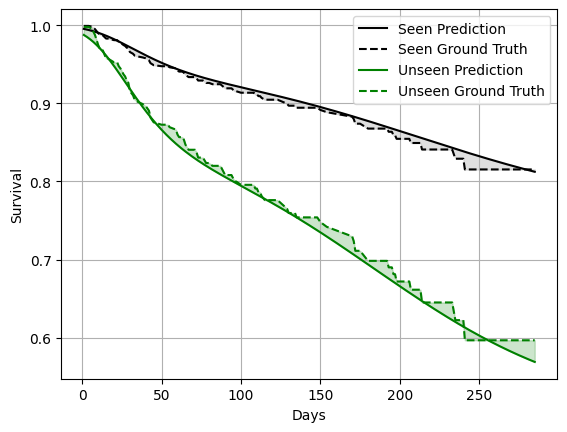

In [ ]:
# inference
import matplotlib.pyplot as plt
seen_patient, seen_truth = train_dataset[10]
unseen_patient, unseen_truth = test_dataset[2]

times = torch.linspace(0,1,285)[:,None].cuda()
# for model, model_type in zip([mlp_model, onet_model],["MLP Function", "Gelu DeepONet"]):
# for i, model in enumerate(model_list):
model.eval()
seen_pred = torch.as_tensor(model(seen_patient.cuda()[None,:], times, final_act=final_act))
unseen_pred = torch.as_tensor(model(unseen_patient.cuda()[None,:], times, final_act=final_act))

if isinstance(seen_truth, torch.Tensor):
  seen_truth = seen_truth.detach().numpy()
  unseen_truth = unseen_truth.detach().numpy()
seen_pred = seen_pred.cpu().detach().numpy()
unseen_pred = unseen_pred.cpu().detach().numpy()


if len(seen_pred.shape) > 1:
  seen_pred = np.reshape(seen_pred, (-1))
  unseen_pred = np.reshape(unseen_pred, (-1))

fig, ax = plt.subplots(1,1)
days = np.arange(1,286)
ax.plot(days, seen_pred, "-k", label="Seen Prediction")
ax.plot(days, seen_truth, "--k", label="Seen Ground Truth")
ax.plot(days, unseen_pred, "-g", label="Unseen Prediction")
ax.plot(days, unseen_truth, "--g", label="Unseen Ground Truth")
ax.fill_between(days, np.min(np.vstack([seen_pred, seen_truth]), axis=0), np.max(np.vstack([seen_pred, seen_truth]), axis=0), color="silver", alpha=0.5)
ax.fill_between(days, np.min(np.vstack([unseen_pred, unseen_truth]), axis=0), np.max(np.vstack([unseen_pred, unseen_truth]), axis=0), color="green", alpha=0.2)
plt.grid(True)
# plt.title(f"Fold {i}")
plt.xlabel("Days")
plt.ylabel("Survival")
plt.legend(loc='best')
plt.savefig(f"{save_dir}/{NET_NAME}_inference.png")
plt.show()

In [ ]:
# plot basis
# for model, model_type in zip([onet_model],["Siren DeepONet"]):
for j, model in enumerate(model_list):
  v = model.trunk_net(times).cpu().detach().numpy()
  fig, ax = plt.subplots(1,1)
  days = np.arange(1,286)
  for i, f in enumerate(v.T):
    ax.plot(days, f, label=str(i))
  plt.legend(loc='best')
  plt.grid(True)
  plt.title(f"Fold {j} Basis Functions")
  plt.xlabel("Days")

  weights = np.ones(285)
  weights[0] = 0.5
  weights[-1] = 0.5
  weights = np.diag(weights)

  v1 = model.trunk_net(times).cpu().detach().numpy()
  v1_norms = np.sqrt(np.diag(v1.T @ weights @ v1))
  v1 = v1 / v1_norms

  v1_ortho = np.abs(v1.T @ weights @ v1)

  fig, ax = plt.subplots(1,1)
  plt.imshow(v1_ortho)
  plt.colorbar()
  plt.title("ONet Basis Non-Orthogonality")

plt.show()

NameError: name 'model_list' is not defined

In [ ]:
# Suggested Treatment
# model = model_list[1]
# get sensitivity of survival probability \int_0^t p(t|x) dt wrt x
patient, current_true = test_dataset[2]
# mask variables that cannot be improved
mask = torch.tensor([0,1,1,0,1,0,0,1,1,0,0]).cuda()

# use L2 norm of survival curve
x = torch.nn.Parameter(patient.cuda())
steps = [x.cpu().detach().numpy()]
survival_curves = []
optimizer = SGD([x], 0.005, maximize=True)
optimizer.zero_grad()
pred = model(x[None,:], times, final_act=final_act)
survival_curves.append(pred.cpu().detach().numpy())
loss = timeseries_L2_loss(pred, torch.zeros_like(pred))
loss.backward()
x.grad = x.grad * mask
optimizer.step()
next=x.cpu().detach()
next = train_dataset.inv_transform(next)
next[1] = max(min(next[1],1), 0)
next[2] = max(next[2], 20)
next[4] = max(min(next[4], 100),0)
next[7] = max(next[7], 0.6)
next[8] = max(min(next[8], 145),0)
steps.append(next)

next = train_dataset.transform(next).cuda().float()
pred = model(next[None,:], times, final_act=final_act)
survival_curves.append(pred.cpu().detach().numpy())

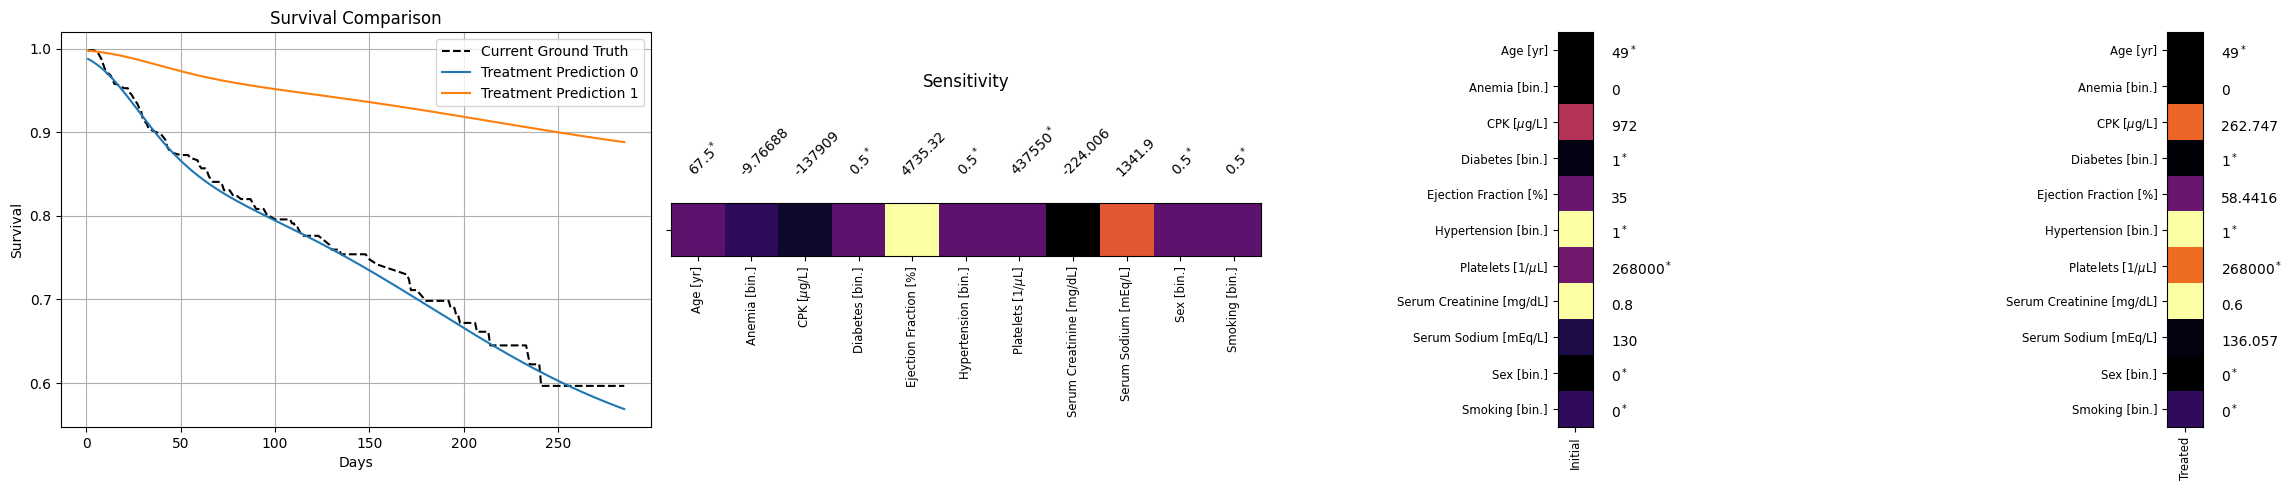

In [ ]:
# plot survival comparison
fig, axs = plt.subplots(1,4, figsize=(25,5))

axs[0].plot(days, current_true.cpu().detach().numpy(), "--k", label="Current Ground Truth")
for i,curve in enumerate(survival_curves):
  axs[0].plot(days, curve.ravel(), label="Treatment Prediction {}".format(i))
axs[0].legend(loc='best')
axs[0].set_title("Survival Comparison")
axs[0].set_xlabel("Days")
axs[0].set_ylabel("Survival")
axs[0].grid(True)

xt = ["Age [yr]","Anemia [bin.]","CPK [$\mu$g/L]","Diabetes [bin.]","Ejection Fraction [%]","Hypertension [bin.]","Platelets [1/$\mu$L]","Serum Creatinine [mg/dL]","Serum Sodium [mEq/L]","Sex [bin.]","Smoking [bin.]"]
extent=[.5, x.grad.shape[0]+.5, .5, 1.5]
im1 = axs[1].imshow(x.grad.cpu().detach().numpy()[None,:], aspect="equal", extent=extent, cmap="inferno")
for y,g in enumerate(train_dataset.inv_transform(x.grad.cpu()).detach().numpy()):
  if mask[y] == 0:
    axs[1].text(y + 0.75, 2, "{:g}$^*$".format(g.item()), rotation=45)
  else:
    axs[1].text(y + 0.75, 2, "{:g}".format(g.item()), rotation=45)
# axs[1].text(4,-1.25, "$^*$ Variable cannot be improved")
# ax2.set_yticks(1+np.flip(np.arange(len(yt))), x.grad.cpu().detach().numpy(), size='small')
# im1 = axs[1].imshow(np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0]]).T, aspect="equal", extent=extent, cmap="inferno")
# plt.colorbar(im1)
axs[1].set_yticks([1], [""], size='small')
axs[1].set_xticks(1+(np.arange(len(xt))), xt, size='small')
axs[1].tick_params(axis='x', labelrotation=90)
axs[1].set_title("Sensitivity", y=3)

x_untreated = np.flip(np.asarray(steps[0]))[:,None]
extent=[.5, x_untreated.shape[1]+.5, .5, x_untreated.shape[0]+.5]
im2 = axs[2].imshow(x_untreated, aspect="equal", extent=extent, cmap="inferno")
x_untreated = train_dataset.inv_transform(torch.tensor(np.flip(x_untreated.T, 1))).detach().numpy().ravel()
axs[2].set_yticks(1+np.flip(np.arange(len(yt))), yt, size='small')
for y,x_u in enumerate(x_untreated):
  if mask[y] == 0:
    axs[2].text(2, 10.75 - y, "{:g}$^*$".format(x_u.item()))
  else:
    axs[2].text(2, 10.75 - y, "{:g}".format(x_u.item()))
xt = ["Initial"]
axs[2].set_xticks(1+np.arange(len(xt)), xt, size='small')
axs[2].tick_params(axis='x', labelrotation=90)


x_treated = np.asarray(steps[1])[:,None]
x_treat_norm = torch.flip(train_dataset.transform(torch.tensor(x_treated.T)).T, [0])
extent=[.5, x_treated.shape[1]+.5, .5, x_treated.shape[0]+.5]
im3 = axs[3].imshow(x_treat_norm, aspect="equal", extent=extent, cmap="inferno")
axs[3].set_yticks(1+np.flip(np.arange(len(yt))), yt, size='small')
for y,x_t in enumerate(x_treated):
  if mask[y] == 0:
    axs[3].text(2, 10.75 - y, "{:g}$^*$".format(x_t.item()))
  else:
    axs[3].text(2, 10.75 - y, "{:g}".format(x_t.item()))
xt = ["Treated"]
axs[3].set_xticks(1+np.arange(len(xt)), xt, size='small')
axs[3].tick_params(axis='x', labelrotation=90)

fig.tight_layout()
plt.show()

In [ ]:
# model treatment over time
treatments = []
rates = [1e-6,3e-6,9e-6,3e-5]
improvement_hists=[]
for rate in rates:

  x = torch.nn.Parameter(patient.cuda())
  steps = [x.cpu().detach().numpy()]
  survival_curves = []

  for day in range(284):
    # x.grad = torch.zeros_like(x)
    if day == 0:
      pred = model(x[None,:], times, final_act=final_act)
    else:
      pred = model(x[None,:], times[day:], final_act=final_act)
    survival_curves.append(pred.cpu().detach().numpy())
    loss = timeseries_L2_loss(pred, torch.zeros_like(pred))
    loss.backward()
    x.grad = x.grad * mask
    x = x + x.grad * rate
    x = train_dataset.inv_transform(x.cpu()) + torch.tensor([1/365,0,0,0,0,0,0,0,0,0,0])
    x[1] = max(min(x[1],1), 0)
    x[2] = max(x[2], 20)
    x[4] = max(min(x[4], 100),0)
    x[7] = max(x[7], 0.6)
    x[8] = max(min(x[8], 145),0)
    steps.append(x.detach().numpy())
    x = x.detach()
    x = train_dataset.transform(x).cuda().float()
    x.requires_grad_(True)

  # create cumulative survival curve
  total_survival = np.ones(len(times))
  for i,curve in enumerate(survival_curves):
    total_survival[i:] = curve
  treatments.append(total_survival)
  improvement_hists.append(steps)

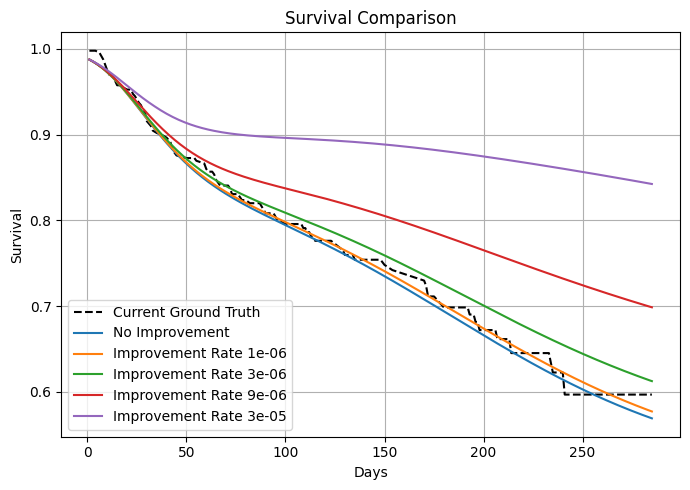

In [ ]:
# plot total survival comparison
fig, axs = plt.subplots(1,1, figsize=(7,5))
axs.plot(days, current_true.cpu().detach().numpy(), "--k", label="Current Ground Truth")
axs.plot(days, survival_curves[0].ravel(), label="No Improvement")
for survival, rate in zip(treatments, rates):
  axs.plot(days, survival.ravel(), label="Improvement Rate {}".format(rate))
axs.legend(loc='best')
axs.set_title("Survival Comparison")
axs.set_xlabel("Days")
axs.set_ylabel("Survival")
axs.grid(True)

# for rate, steps in zip(rates,improvement_hists):
#   steps = np.asarray(steps)[:,np.where(mask.cpu().detach().numpy())]
#   steps = np.squeeze(steps)
#   var_names = ["Anemia [bin.]","CPK [$\mu$g/L]","Ejection Fraction [%]","Serum Creatinine [mg/dL]","Serum Sodium [mEq/L]"]
#   for j, variable in enumerate(steps.T):
#     axs[j+1].plot(days, variable.T, label="Improvement Rate {}".format(rate))
#     axs[j+1].legend(loc='best')
#     axs[j+1].set_xlabel("Days")
#     axs[j+1].set_ylabel(var_names[j])
#     axs[j+1].grid(True)
# plt.colorbar(im2)

fig.tight_layout()
plt.show()